In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
%matplotlib inline
pd.set_option('display.max_columns', 500)

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

from datetime import datetime, timedelta
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [4]:
import torch
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [5]:
log_train = r'./data/log_train.csv'
log_test = r'./data/log_test.csv'
train = r'./data/train.csv'
test = r'./data/test.csv'
sample_sub = r'./data/sample_submission.csv'


log_train_df = pd.read_csv(log_train)
log_test_df = pd.read_csv(log_test)
train_df = pd.read_csv(train)
test_df = pd.read_csv(test)
sample_sub_df = pd.read_csv(sample_sub)

In [6]:
print(f"log_train {log_train_df.shape}")
print(f"log_test {log_test_df.shape}")
print(f"train {train_df.shape}")
print(f"test {test_df.shape}")

log_train (5710093, 5)
log_test (2447184, 5)
train (84377, 141)
test (35982, 140)


In [7]:
print(f"Submission Sample {sample_sub_df.shape}")

Submission Sample (35982, 2)


In [8]:
# For how many IDs do we have logs in train data
sum(train_df.ID.isin(log_train_df.ID))

47695

# LOG FILE PROCESSING

#### Converting to datetime

In [9]:
# Convert to Date time
log_train_df.time = pd.to_datetime(log_train_df.time, format="%Y-%m-%dT%H:%M:%S")

In [10]:
log_train_df['date_only'] = log_train_df['time'].dt.date
log_train_df['week_number'] = log_train_df['time'].dt.isocalendar().week

In [11]:
log_train_df.head(2)

,ID,time,source,event,object,date_only,week_number
0,43980,2013-11-11 16:30:11,browser,page_close,3T6XwoiMKgol57cm29Rjy8FXVFcIomxl,2013-11-11,46
1,2648,2013-12-27 06:44:08,browser,access,UaqaZdJXEAHfzB9qbZkvAe2jc0xmI3Na,2013-12-27,52


In [12]:
# Range of logs
min(log_train_df.date_only), max(log_train_df.date_only)

(datetime.date(2013, 10, 27), datetime.date(2014, 8, 1))

In [13]:
# Unique events we have
log_train_df['event'].unique()

array(['page_close', 'access', 'navigate', 'video', 'problem',
       'discussion', 'wiki'], dtype=object)

In [14]:
log_features_df = pd.DataFrame(log_train_df.ID.unique(), columns=['ID'])

#### Encoding Events in Logs

In [15]:
encoder = OneHotEncoder()
labelencoder = LabelEncoder()

In [16]:
log_train_df['event_categorical'] = labelencoder.fit_transform(log_train_df[['event']])

/Users/nmnsnghl/anaconda3/envs/torch_temp/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
enc_df = pd.DataFrame(encoder.fit_transform(log_train_df[['event_categorical']]).toarray())
log_train_df = log_train_df.join(enc_df)

##### Renaming encoded columns

In [18]:
decoded_labels_event = list(labelencoder.inverse_transform([0,1,2,3,4,5,6]))
decoded_labels_event = list(map(lambda x: 'event_'+x,decoded_labels_event))
decoded_labels_event = dict(zip(range(len(labelencoder.classes_)), decoded_labels_event))

In [19]:
# Renaming encoded cols
log_train_df = log_train_df.rename(decoded_labels_event, axis=1)

In [20]:
# drop event and time
# log_train_df.drop(['event', 'event_categorical', 'time'], axis=1, inplace=True)

In [21]:
log_train_df.head(2)

,ID,time,source,event,object,date_only,week_number,event_categorical,event_access,event_discussion,event_navigate,event_page_close,event_problem,event_video,event_wiki
0,43980,2013-11-11 16:30:11,browser,page_close,3T6XwoiMKgol57cm29Rjy8FXVFcIomxl,2013-11-11,46,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2648,2013-12-27 06:44:08,browser,access,UaqaZdJXEAHfzB9qbZkvAe2jc0xmI3Na,2013-12-27,52,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Extraction from Logs

#### 1. Average session per week

In [22]:
sessions_by_week = log_train_df[['ID', 'week_number', 'source']].groupby(['ID', 'week_number']).count().reset_index()


In [23]:
processed_logs = sessions_by_week[['ID', 'source']].groupby(['ID']).mean('source').reset_index()
processed_logs.columns = ['ID', 'session_by_week']

#### 2. Active days per week

In [24]:
grouped_date_by_week = log_train_df.groupby(['ID', 'week_number', 'date_only']).count().reset_index()[['ID', 'week_number', 'date_only']]
grouped_date_by_week = grouped_date_by_week.groupby(['ID', 'week_number']).count().reset_index()

In [25]:
grouped_date_by_week.head(2)

,ID,week_number,date_only
0,1,24,1
1,1,25,3


In [26]:
active_per_week = grouped_date_by_week[['ID', 'date_only']].groupby(['ID']).mean('date_only').reset_index()
active_per_week.columns = ['ID', 'active_per_week']

In [27]:
# Merge to processed data
processed_logs = processed_logs.merge(active_per_week, on='ID')

#### 3. Each event average per week

In [28]:
events_by_week_orig = log_train_df[['ID', 'week_number']+list(decoded_labels_event.values())]
events_by_week = events_by_week_orig.groupby(['ID', 'week_number']).sum().reset_index()
events_by_week = events_by_week.groupby(['ID']).mean().reset_index().drop('week_number', axis=1)

In [29]:
events_by_week.columns = ['ID'] + list(map(lambda x: x + '_by_week', list(decoded_labels_event.values())))

In [30]:
# Merge to processed data, drop wiki
processed_logs = processed_logs.merge(events_by_week, on='ID').iloc[:,:-1]

In [31]:
processed_logs.head(5)

,ID,session_by_week,active_per_week,event_access_by_week,event_discussion_by_week,event_navigate_by_week,event_page_close_by_week,event_problem_by_week,event_video_by_week
0,1,47.40,2.80,17.00,0.0,3.4,10.40,12.20,4.4
1,3,39.00,1.80,11.00,3.8,2.0,3.80,17.00,1.4
2,4,17.75,2.25,11.75,0.0,2.5,1.25,1.25,1.0
3,5,86.60,2.20,32.00,4.2,3.8,13.00,22.20,11.4
4,6,16.00,2.00,10.00,0.0,4.0,0.00,2.00,0.0


#### Total Event per Quarter

In [32]:
log_train_df['Quarter'] = np.ceil(log_train_df.week_number/13)

In [33]:
events_by_quarter = log_train_df[['ID', 'Quarter']+list(decoded_labels_event.values())]
events_by_quarter = events_by_quarter.groupby(['ID', 'Quarter']).sum().reset_index()
events_by_quarter = events_by_quarter.groupby(['ID']).mean().reset_index().drop('Quarter', axis=1)

In [34]:
events_by_quarter.columns = ['ID'] + list(map(lambda x: x + '_by_q', list(decoded_labels_event.values())))
# drop wiki
events_by_quarter = events_by_quarter.iloc[:,:-1]

In [35]:
# Merge to processed data
processed_logs = processed_logs.merge(events_by_quarter, on='ID')

#### Total events

In [36]:
events = events_by_week_orig.groupby(['ID']).sum().reset_index().iloc[:,:-1].drop('week_number', axis=1)

In [37]:
# Merge to processed data
processed_logs = processed_logs.merge(events, on='ID')

#### Days active

In [38]:
days_active = log_train_df.groupby(['ID', 'date_only']).count().reset_index()[['ID', 'object']]
days_active = days_active.groupby(['ID']).count().reset_index()

In [39]:
days_active.columns = ['ID', 'days_active']
# Merge to processed data
processed_logs = processed_logs.merge(days_active, on='ID')

#### Video consumption time

In [40]:
filtered_video_obj = log_train_df[log_train_df.event.isin(['page_close', 'video'])][['ID', 'time', 'event', 'object']]
filtered_video_obj = filtered_video_obj.sort_values(['ID', 'time'], ascending=False)

In [41]:
filtered_video_obj.shape

(1423273, 4)

In [42]:
%%time
# Calculating only for IDs we need due to performance
temp_copy = filtered_video_obj[filtered_video_obj['ID'].isin(train_df['ID']) | filtered_video_obj['ID'].isin(test_df['ID'])].copy()

processed_logs['total_video_time'] = 0

forward_drop_ID = []

def cal_consumption(row):
    global forward_drop_ID
    
    obj = row['object']
    event = row['event']
    time = row['time']
    ID = row['ID']
    
    if row.name in forward_drop_ID:
        forward_drop_ID.remove(row.name)
        return
    
    watch_time = 0
    
    if event == 'video':
        # a video which was not closed
        temp_copy.drop(row.name, inplace=True)
    else:
        try:
            first_occurrence_index = temp_copy[(temp_copy['event'] == 'video')
                                               & (temp_copy['object'] == obj)
                                               & (temp_copy['ID'] == ID)].head(1).index.values[0]
        except IndexError:
            ...
        else:
            start_time = temp_copy[temp_copy.index==first_occurrence_index].time.values[0]
            watch_time = time-start_time
            temp_copy.drop(first_occurrence_index, inplace=True)
            forward_drop_ID.append(first_occurrence_index)
        
    return (ID, watch_time)

"""
# Apply the function to each row and filter out None results
results = temp_copy.apply(cal_consumption, axis=1)
results = filter(lambda x: x is not None and not isinstance(x[1], int), results)
print("Done part 1")

# Convert watch time to seconds and add to processed_logs
for ID, watch_time in results:
    processed_logs.loc[processed_logs['ID'] == ID, 'total_video_time'] += watch_time.total_seconds()
"""

for index, row in tqdm(temp_copy.iterrows(), total=len(temp_copy)):
    result = cal_consumption(row)
    
    if result is None:
        # forward dropped
        continue
    
    if not isinstance(result[1], int):
        processed_logs.loc[processed_logs['ID'] == result[0], 'total_video_time'] += result[1].total_seconds()

100%|██████████████████████████████████████████████████████████████████████████████████████| 844630/844630 [11:27:06<00:00, 20.49it/s]

CPU times: user 7h 49min 50s, sys: 17min 55s, total: 8h 7min 45s
Wall time: 11h 27min 6s


In [43]:
processed_logs.to_csv('processed_logs.csv', index=False)

In [46]:
processed_logs['total_video_time'].unique()

array([      0, 9482481, 8709941, ...,     424,    1438,    1720])

# TRAIN DATA PREP

In [47]:
train_df.label.value_counts()

label
1    66888
0    17489
Name: count, dtype: int64

Imbalanced dataset

In [48]:
train_df.describe()

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,label
count,83912.000000,83959.000000,25179.0,83946.000000,25131.0,83947.000000,25137.0,25272.0,83967.000000,84008.000000,83975.000000,83987.000000,83955.000000,83973.000000,83929.000000,83963.000000,83962.000000,83959.000000,25240.0,25093.0,25197.0,25327.0,25281.0,25093.0,25230.0,83958.000000,83965.000000,83970.000000,83976.000000,83980.000000,83988.000000,83941.000000,83953.000000,83958.000000,83944.000000,83948.000000,83905.000000,83976.000000,25171.0,25436.0,25115.0,83978.000000,83928.000000,83930.000000,83970.000000,83974.000000,25211.0,83930.000000,83965.000000,83961.000000,83986.000000,25048.0,83951.000000,25099.0,25311.0,25099.0,83956.000000,83965.000000,25077.0,25161.0,25156.0,25098.0,25418.0,25140.0,83919.000000,83948.000000,25261.0,25184.0,25435.0,83939.000000,25055.0,25360.0,83950.000000,25060.0,83973.000000,25255.0,25385.0,83929.000000,83948.000000,83941.000000,83957.000000,83941.000000,83962.000000,83961.000000,83965.000000,83953.000000,83966.000000,83951.000000,25225.0,25196.0,83989.000000,25059.0,83949.000000,25235.0,25077.0,83960.000000,83968.000000,83968.000000,83953.000000,83971.000000,83963.000000,83956.000000,83928.000000,83940.000000,83952.000000,83991.000000,25141.0,83996.000000,83954.000000,83980.000000,84007.000000,83977.00000,83987.000000,83972.000000,83936.000000,83948.000000,83924.000000,83951.000000,83963.000000,25207.0,25337.0,83933.000000,83945.000000,25247.0,25044.0,83961.000000,83936.000000,83966.000000,83943.000000,25202.0,25392.0,25084.0,25185.0,25367.0,83936.000000,83985.000000,83967.000000,83929.000000,83966.000000,24981.0,84377.000000
mean,100386.093098,1.585512,0.0,11.740988,0.0,1.906763,0.0,0.0,9.415139,9.026486,8.502042,7.922631,12.688667,12.633084,12.551907,8.093160,8.052988,13.831430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.464363,12.650914,12.716625,12.850088,12.793498,12.518324,12.419068,12.467690,12.566521,12.744222,12.718552,2.238424,10.132216,0.0,0.0,0.0,11.176522,10.173101,10.701430,2.238883,12.504930,0.0,11.031371,11.236634,27.014054,1.000905,0.0,7.731510,0.0,0.0,0.0,7.316166,6.305294,0.0,0.0,0.0,0.0,0.0,0.0,1.000027,1.005212,0.0,0.0,0.0,1.005379,0.0,0.0,10.774771,0.0,2480.769307,0.0,0.0,6.824398,9.021037,9.182378,8.278190,12.029473,9.518056,8.967390,8.999464,8.849535,9.222435,9.869364,0.0,0.0,5.055471,0.0,9.413108,0.0,0.0,6.836446,8.840713,9.683141,10.946494,7.827309,7.863607,9.760779,12.341853,11.228651,10.792322,10.703159,0.0,12.306515,12.273638,12.440545,12.446260,12.90395,12.564635,12.469680,12.633816,4.208808,12.516813,12.551607,9.410776,0.0,0.0,5.061282,7.363285,0.0,0.0,1.142852,1.129956,11.095181,20.785152,0.0,0.0,0.0,0.0,0.0,2.381040,2.567792,2.254326,2.334092,5.735965,0.0,0.792728
std,57993.333045,0.535283,0.0,34.643444,0.0,1.036347,0.0,0.0,17.288043,15.491942,13.644927,12.402860,12.810191,12.963943,12.529402,14.503711,13.481138,28.882368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.875154,14.637749,13.891236,14.432178,14.334957,13.703340,13.278109,13.249692,13.267787,14.165527,14.466292,3.511218,30.026372,0.0,0.0,0.0,31.218848,30.090452,32.437012,3.507194,35.744037,0.0,29.840560,31.884643,54.615948,0.054987,0.0,22.415262,0.0,0.0,0.0,8.973501,11.724296,0.0,0.0,0.0,0.0,0.0,0.0,0.005613,0.301954,0.0,0.0,0.0,0.122192,0.0,0.0,7.008842,0.0,2114.301087,0.0,0.0,8.633683,13.711790,14.127946,12.354702,11.045928,19.138137,13.778297,13.594101,13.435822,13.798543,15.591675,0.0,0.0,7.904405,0.0,13.142299,0.0,0.0,5.876158,13.

##### Drop dummy columns

In [49]:
drop_cols = []
mean_of_train = pd.DataFrame(train_df.mean()).reset_index()
keep_features = mean_of_train[mean_of_train.iloc[:,-1]!=0.0]['index'].to_list()

In [50]:
def filter_dummy_cols(dataset, keep):
    return dataset[keep]

In [51]:
train_df = filter_dummy_cols(train_df, keep_features)
train_df.head(2)

,ID,X1,X3,X5,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X41,X42,X43,X44,X45,X47,X48,X49,X50,X52,X56,X57,X64,X65,X69,X72,X74,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X90,X92,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X121,X122,X125,X126,X127,X128,X134,X135,X136,X137,X138,label
0,7054.0,2.015152,32.0,4.0,7.0,6.0,2.0,5.0,2.0,15.0,16.0,6.0,9.0,10.0,8.0,1.0,14.0,16.0,39.0,16.0,13.0,8.0,4.0,15.0,4.0,2.0,2.0,2.0,1.0,1.0,2.0,3.0,2.0,2.0,21.0,1.0,10.0,9.142857,1.0,1.0,1.0,1.0,18.0,2574.0,5.83871,7.0,1.0,5.0,8.0,11.0,27.0,2.0,3.0,6.0,4.0,1.000000,5.0,4.0,5.0,4.0,1.0,1.0,4.0,5.0,16.0,13.0,7.0,13.0,14.0,5.0,13.0,9.0,15.0,2.0,14.0,6.0,2.0,11.0,4.0,5.0,2.0,10.0,1.0,1.0,18.0,13.0,1.0,1.0,1.0,3.0,2.0,1
1,147131.0,1.000000,2.0,NaN,6.0,5.0,8.0,4.0,7.0,12.0,1.0,4.0,7.0,3.0,13.0,7.0,13.0,15.0,17.0,12.0,14.0,8.0,9.0,4.0,14.0,1.0,1.0,2.0,2.0,11.0,1.0,2.0,1.0,1.0,4.0,1.0,2.0,1.000000,3.0,1.0,1.0,1.0,16.0,961.0,1.75188,1.0,10.0,6.0,8.0,3.0,3.0,11.0,9.0,9.0,3.0,1.862069,4.0,2.0,2.0,4.0,8.0,2.0,1.0,3.0,5.0,9.0,16.0,16.0,4.0,3.0,1.0,14.0,2.0,16.0,14.0,17.0,1.0,4.0,6.0,4.0,2.0,1.0,1.0,1.0,9.0,4.0,3.0,1.0,1.0,2.0,10.0,1


In [52]:
train_df.shape

(84377, 92)

So we removed 48 dummy columns, haha you can't trick me :)

In [53]:
train_df.describe()

,ID,X1,X3,X5,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X41,X42,X43,X44,X45,X47,X48,X49,X50,X52,X56,X57,X64,X65,X69,X72,X74,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X90,X92,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X121,X122,X125,X126,X127,X128,X134,X135,X136,X137,X138,label
count,83912.000000,83959.000000,83946.000000,83947.000000,83967.000000,84008.000000,83975.000000,83987.000000,83955.000000,83973.000000,83929.000000,83963.000000,83962.000000,83959.000000,83958.000000,83965.000000,83970.000000,83976.000000,83980.000000,83988.000000,83941.000000,83953.000000,83958.000000,83944.000000,83948.000000,83905.000000,83976.000000,83978.000000,83928.000000,83930.000000,83970.000000,83974.000000,83930.000000,83965.000000,83961.000000,83986.000000,83951.000000,83956.000000,83965.000000,83919.000000,83948.000000,83939.000000,83950.000000,83973.000000,83929.000000,83948.000000,83941.000000,83957.000000,83941.000000,83962.000000,83961.000000,83965.000000,83953.000000,83966.000000,83951.000000,83989.000000,83949.000000,83960.000000,83968.000000,83968.000000,83953.000000,83971.000000,83963.000000,83956.000000,83928.000000,83940.000000,83952.000000,83991.000000,83996.000000,83954.000000,83980.000000,84007.000000,83977.00000,83987.000000,83972.000000,83936.000000,83948.000000,83924.000000,83951.000000,83963.000000,83933.000000,83945.000000,83961.000000,83936.000000,83966.000000,83943.000000,83936.000000,83985.000000,83967.000000,83929.000000,83966.000000,84377.000000
mean,100386.093098,1.585512,11.740988,1.906763,9.415139,9.026486,8.502042,7.922631,12.688667,12.633084,12.551907,8.093160,8.052988,13.831430,12.464363,12.650914,12.716625,12.850088,12.793498,12.518324,12.419068,12.467690,12.566521,12.744222,12.718552,2.238424,10.132216,11.176522,10.173101,10.701430,2.238883,12.504930,11.031371,11.236634,27.014054,1.000905,7.731510,7.316166,6.305294,1.000027,1.005212,1.005379,10.774771,2480.769307,6.824398,9.021037,9.182378,8.278190,12.029473,9.518056,8.967390,8.999464,8.849535,9.222435,9.869364,5.055471,9.413108,6.836446,8.840713,9.683141,10.946494,7.827309,7.863607,9.760779,12.341853,11.228651,10.792322,10.703159,12.306515,12.273638,12.440545,12.446260,12.90395,12.564635,12.469680,12.633816,4.208808,12.516813,12.551607,9.410776,5.061282,7.363285,1.142852,1.129956,11.095181,20.785152,2.381040,2.567792,2.254326,2.334092,5.735965,0.792728
std,57993.333045,0.535283,34.643444,1.036347,17.288043,15.491942,13.644927,12.402860,12.810191,12.963943,12.529402,14.503711,13.481138,28.882368,13.875154,14.637749,13.891236,14.432178,14.334957,13.703340,13.278109,13.249692,13.267787,14.165527,14.466292,3.511218,30.026372,31.218848,30.090452,32.437012,3.507194,35.744037,29.840560,31.884643,54.615948,0.054987,22.415262,8.973501,11.724296,0.005613,0.301954,0.122192,7.008842,2114.301087,8.633683,13.711790,14.127946,12.354702,11.045928,19.138137,13.778297,13.594101,13.435822,13.798543,15.591675,7.904405,13.142299,5.876158,13.763075,15.438324,18.383853,19.699956,20.486866,17.188237,12.149863,8.642964,7.154563,6.637250,12.994317,13.227290,13.381765,14.169567,14.90645,13.884921,18.330795,15.361021,6.271950,14.445830,13.340087,13.137741,8.752162,22.402294,2.659613,2.491213,8.140023,38.831352,2.050817,2.086498,1.989084,2.029105,2.988488,0.405355
min,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,119.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0

##### Handling Missing Data in Train

In [54]:
train_df.isna().sum()

ID       465
X1       418
X3       431
X5       430
X8       410
        ... 
X135     392
X136     410
X137     448
X138     411
label      0
Length: 92, dtype: int64

In [55]:
train_df = train_df.dropna(subset=['ID'])
# we fill all na with minimum which is 1.0
train_df = train_df.fillna(1.0)

In [47]:
#top_15_features = list(train_df.corr().abs().sort_values('label', ascending=False)['label'].head(15).index)

#sns.heatmap(train_df[top_15_features].corr().abs())

In [48]:
#train_df = train_df[top_15_features+['ID']]

In [56]:
top_15_features = list(train_df.corr().abs().sort_values('label', ascending=False)['label'].head(10).index)

##### Merging Processed Logs to Train data

<Axes: >

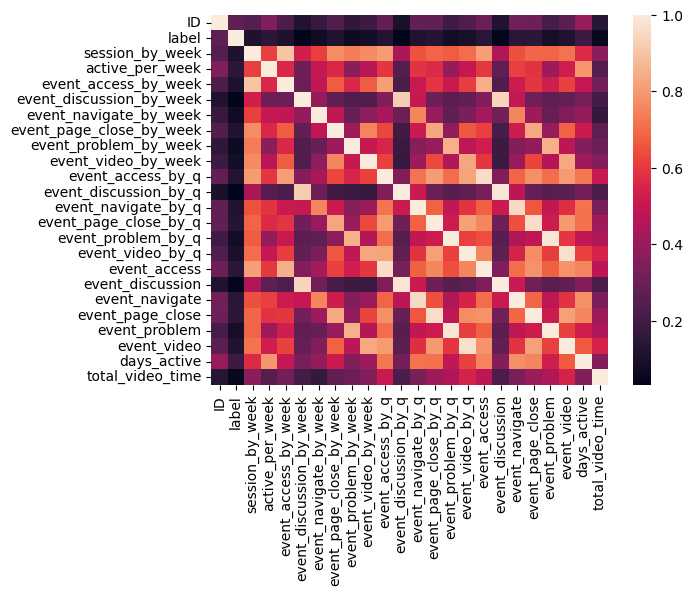

In [57]:
sns.heatmap(train_df[['ID', 'label']].merge(processed_logs, on='ID', how = 'left').corr().abs())

In [58]:
train_df = train_df.merge(processed_logs, on='ID', how = 'left')

In [59]:
train_df.isna().sum()

ID                      0
X1                      0
X3                      0
X5                      0
X8                      0
                    ...  
event_page_close    36217
event_problem       36217
event_video         36217
days_active         36217
total_video_time    36217
Length: 114, dtype: int64

In [60]:
# Handling NaNs
train_df.fillna(0, inplace=True)
#train_df.dropna(axis=0, inplace=True)

In [54]:
# Undersampling 1 - RESULT USELESS - problem in data itself
'''
temp_train_df = train_df[train_df.label==1].sample(n=int(sum(train_df.label==0)*1.2), random_state=42)
train_df = pd.concat([temp_train_df, train_df[train_df.label==0]])'''

'\ntemp_train_df = train_df[train_df.label==1].sample(n=int(sum(train_df.label==0)*1.2), random_state=42)\ntrain_df = pd.concat([temp_train_df, train_df[train_df.label==0]])'

In [61]:
train_df.label.value_counts()

label
1    66520
0    17392
Name: count, dtype: int64

In [62]:
X = train_df.drop(['ID', 'label'], axis=1)
y = train_df['label'].values

In [57]:
# imputer = IterativeImputer()
# X = imputer.fit_transform(X)
# X

##### Scaling and Splitting

In [63]:
sc = StandardScaler()
X = sc.fit_transform(X)

# MODELING

In [64]:
torch.manual_seed(6)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(X_tensor, y_tensor)

In [65]:
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [66]:
batch_size = 1024

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, int(batch_size*2), num_workers=4, pin_memory=True)

In [67]:
for x in train_loader:
    print(x[0].shape)
    break
for x in val_loader:
    print(x[0].shape)
    break

torch.Size([1024, 112])
torch.Size([2048, 112])


### Network

In [108]:
threshold = 0.5

def accuracy(preds, labels):
    global threshold
    binary_predictions = (preds > threshold).float()
    return torch.tensor(torch.sum(binary_predictions == labels).item() / len(preds))


class LogRegDropout(nn.Module):
    def __init__(self, in_size, hidden_size, hidden_size2, out_size):
        super().__init__()
        
        self.layer1 = nn.Linear(in_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, out_size)
        #self.layer3 = nn.Linear(hidden_size2, out_size)
        
    def forward(self, xb):
        """
        Forward pass for training
        """
        out = self.layer1(xb)
        out = F.leaky_relu(out, negative_slope=0.01)
        out = self.layer2(out)
        #out = F.leaky_relu(out, negative_slope=0.01)
        #out = self.layer3(out)
        out = F.sigmoid(out)
        return out
    
    def training_step(self, batch):
        """
        Return loss for batch of training data
        """
        features, labels = batch 
        out = self(features)                  # Generate predictions
        loss = F.binary_cross_entropy_with_logits(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        """
        Scores for single batch
        """
        features, labels = batch 
        out = self(features)                    # Generate predictions
        loss = F.binary_cross_entropy_with_logits(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        """
        Calculates the scores for overall training
        """
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        if (epoch+1)%2 == 0:
            print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))
        

In [69]:
for x in val_loader:
    print(x)
    break

[tensor([[-0.9512, -0.3090,  0.0944,  ..., -0.2130,  0.1731, -0.1023],
        [-1.0878, -0.2512, -0.8715,  ...,  0.1501,  0.1731, -0.1023],
        [-1.0878, -0.2512, -0.8715,  ...,  0.8763,  2.7744, -0.1023],
        ...,
        [ 0.7791, -0.3090,  3.9583,  ..., -0.3340, -0.5701, -0.1023],
        [ 0.7791, -0.3090,  0.0944,  ..., -0.3340,  0.1731, -0.1023],
        [ 0.7791, -0.1067, -0.8715,  ..., -0.2130, -0.1985, -0.1023]]), tensor([[0.],
        [0.],
        [1.],
        ...,
        [1.],
        [1.],
        [0.]])]


In [70]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### GPU Setup

In [71]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    print ("MPS device not found.")

In [72]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [73]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [74]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

### Training

In [109]:
input_size = 112
hidden = 60
#hidden2 = 35
out = 1
epoch = 10
learning_rate = 1e-3

model = LogRegDropout(input_size, hidden, hidden2, out).to(device)

In [110]:
_ += fit(epoch, learning_rate, model, train_loader, val_loader)

Epoch [2], val_loss: 0.4628, val_acc: 0.8579
Epoch [4], val_loss: 0.4586, val_acc: 0.8676
Epoch [6], val_loss: 0.4571, val_acc: 0.8702
Epoch [8], val_loss: 0.4563, val_acc: 0.8720
Epoch [10], val_loss: 0.4562, val_acc: 0.8723


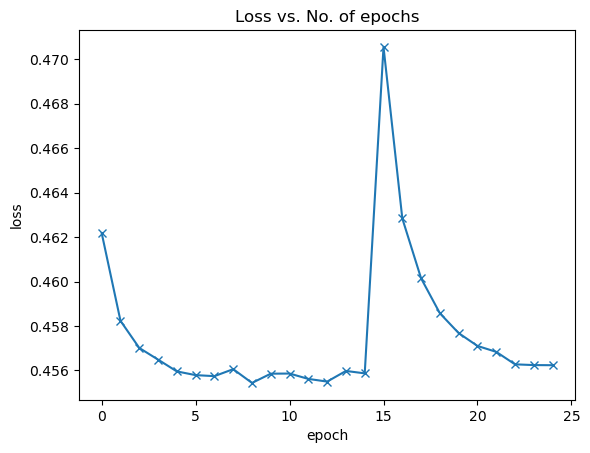

In [111]:
losses = [x['val_loss'] for x in _]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

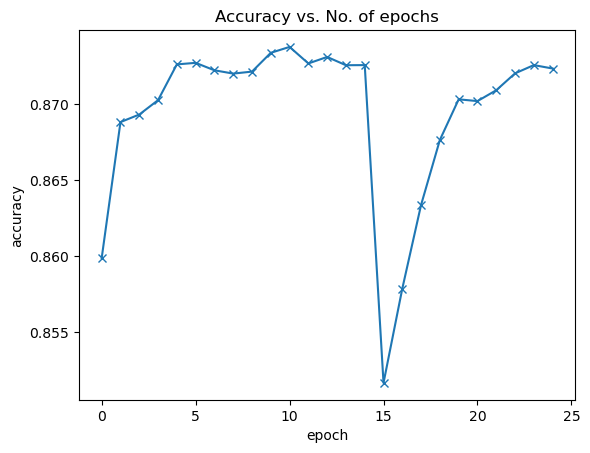

In [112]:
accuracies = [x['val_acc'] for x in _]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

# Submission file

In [91]:
def cleaning_pipeline(df):
    df = filter_dummy_cols(test_df, keep_features[:-1])
    df = df.dropna(subset=['ID'])
    df = df.fillna(1.0)
    
    df = df.merge(processed_logs, on='ID', how = 'left')
    df.fillna(0, inplace=True)
    # df.dropna(axis=0, inplace=True)
    X = df.drop(['ID'], axis=1)
    
    sc = StandardScaler()
    X = sc.fit_transform(X)
    
    
    return torch.tensor(X, dtype=torch.float32).to(device)

In [92]:
def predict(xb, model):
    global threshold
    yb = model(xb.to(device))
    print(yb)
    preds = (yb > threshold).float()
    return preds.to(torch.device('cpu'))

In [93]:
predictions = predict(cleaning_pipeline(test_df), model)

tensor([[0.0074],
        [0.9999],
        [0.9986],
        ...,
        [0.9994],
        [0.9991],
        [0.9991]], device='mps:0', grad_fn=<SigmoidBackward0>)


In [94]:
predictions = np.array(torch.flatten(predictions))

In [95]:
sample_sub_df.head(2)

,ID,label
0,74337.0,0
1,48366.0,0


In [96]:
final_sub = test_df[['ID']]
final_sub['label'] = predictions

/var/folders/l8/l5y_29ps79df27jgbh6xp6n40000gn/T/ipykernel_14284/659565837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sub['label'] = predictions


In [97]:
final_sub.label.value_counts()
# 1    30510
# 0     5472

label
1.0    29261
0.0     6721
Name: count, dtype: int64

In [98]:
final_sub.to_csv('13_NN_logs_watch_time_5epoch.csv',index=False)